# Spatial Features

**Author**: Clarence Mah | **Last Updated**: {sub-ref}`today`

Here we demonstrate how to compute spatial features with. We will use the included MERFISH U2-OS dataset.


## Load Libraries


In [1]:
%load_ext autoreload
%autoreload 2

import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load Data


In [2]:
adata = bt.ds.sample_data()


adata = adata[adata.obs["nucleus_shape"] != None]
bt.sync(adata)
adata


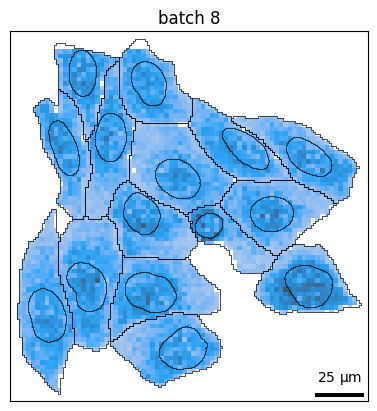

In [3]:
bt.pl.density(adata)


## Shape Features

In `bento` we refer to cell membrane and other subcellular boundaries, e.g. nuclear membrane, as shapes. We can easily inspect morphological properties of these shapes with a number of built-in shape features. Call `bt.tl.list_shape_features()` to list available features.


In [4]:
bt.tl.list_shape_features()


{'area': 'Compute the area of each shape.',
 'aspect_ratio': 'Compute the aspect ratio of the minimum rotated rectangle that contains each shape.',
 'bounds': 'Compute the minimum and maximum coordinate values that bound each shape.',
 'density': 'Compute the RNA density of each shape.',
 'perimeter': 'Compute the perimeter of each shape.',
 'radius': 'Compute the radius of each cell.',
 'raster': 'Generate a grid of points contained within each shape. The points lie on\n    a 2D grid, with vertices spaced `step` distance apart.',
 'second_moment': 'Compute the second moment of each shape.',
 'span': 'Compute the length of the longest diagonal of each shape.'}

For convenience, `bt.tl.obs_stats()` computes the area, aspect ratio, and density properties for the `cell` and `nucleus` shapes.


In [5]:
bt.tl.obs_stats(adata)


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_density, cell_aspect_ratio, cell_area


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_aspect_ratio, nucleus_area, nucleus_density


To visualize feature distributions, run the equivalent plotting function, `bt.pl.obs_stats()`.

The strip plot shows individual cells and the boxes show the 4 quantiles, where the blue are the lower two quantiles and the pink are the upper two quantiles. The vertical black line denotes the 50th quantile.

```{tip}
Spot outlier cells to investigate more closely. These may look very different as a result of poor segmentation or drastically different cell morphology.
```


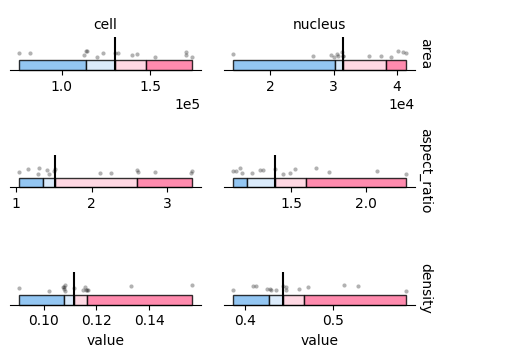

In [6]:
bt.pl.obs_stats(adata)


You may be interested in additional features; the main function you will use is `bt.tl.analyze_shapes()`. Pass `cell_shape` and `area` to compute the area for every cell.


In [7]:
bt.tl.analyze_shapes(adata, "cell_shape", "area")


  0%|          | 0/1 [00:00<?, ?it/s]

Or pass lists of shapes and feature names to compute all combinations simultaneously.


In [8]:
bt.tl.analyze_shapes(
    adata, ["cell_shape", "nucleus_shape"], ["radius", "span", "perimeter"]
)


  0%|          | 0/6 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_perimeter, cell_span, nucleus_radius, cell_perimeter, nucleus_span, cell_radius


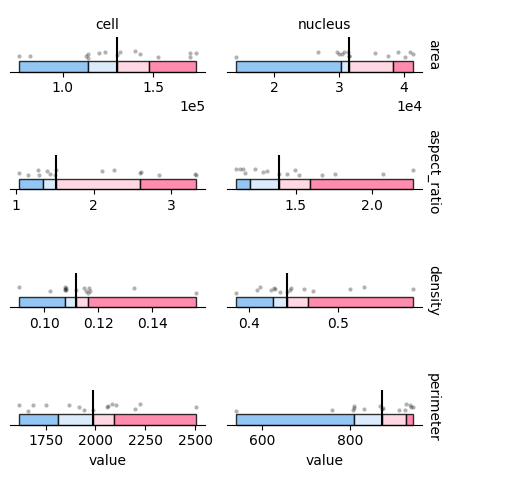

In [9]:
bt.pl.obs_stats(
    adata,
    obs_cols=[
        "cell_area",
        "cell_aspect_ratio",
        "cell_density",
        "nucleus_area",
        "nucleus_aspect_ratio",
        "nucleus_density",
        "nucleus_perimeter",
        "cell_perimeter",
    ],
)


You can use standard python data manipulation/visualization tools to explore features i.e. `pandas` and `seaborn`.

```{note}
Bento tries to simplify quantifying these spatial features, so it is conveninent for downstream exploratory tasks to utilize these feature sets e.g. for studying relationships between cell morphology and other phenotypes, building classifiers etc.
```


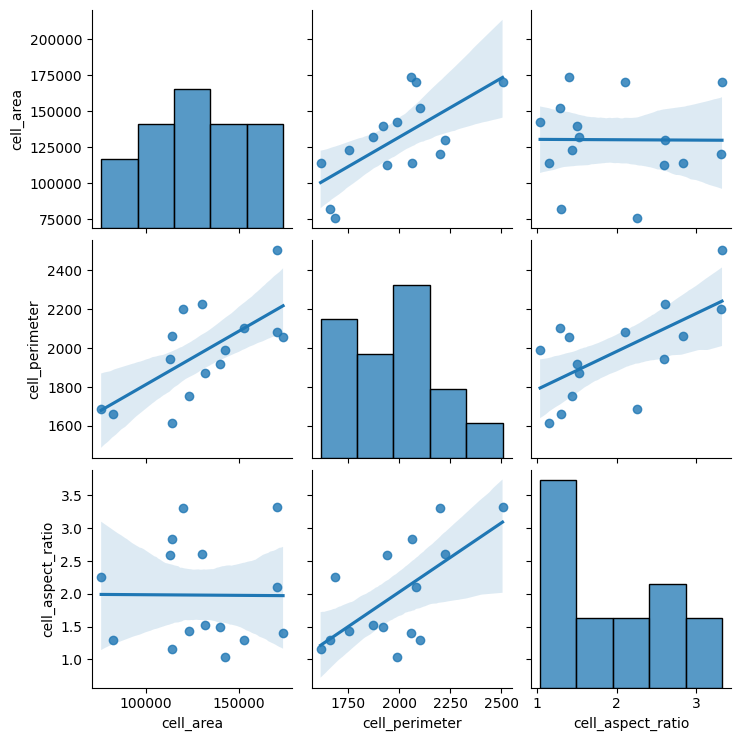

In [10]:
sns.pairplot(
    data=adata.obs[["cell_area", "cell_perimeter", "cell_aspect_ratio"]],
    kind="reg",
)


Let's inspect some potential outliers by plotting cells with extreme `nucleus_density` values.


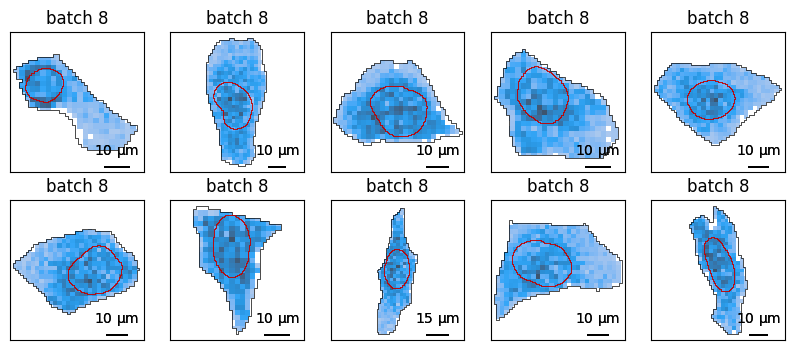

In [11]:
top_cells = adata.obs["nucleus_density"].sort_values(ascending=False).index[:5]
bottom_cells = adata.obs["nucleus_density"].sort_values(ascending=True).index[:5]
cells = [*top_cells, *bottom_cells]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for cell, ax in zip(cells, axes.flat):
    bt.pl.density(adata[cell], ax=ax, square=True, title="", binwidth=20)
    bt.pl.shapes(adata[cell], shapes="nucleus_shape", color="red", ax=ax)


## Point Features

In addition to shape-level features, we can compute subcellular spatial features for arbitrary groups of points, e.g. for every gene.

List available features with `bt.tl.list_point_features`.


In [12]:
bt.tl.list_point_features()


{'proximity': 'For a set of points, computes the proximity of points within `shape_name` as well as the proximity of points outside `shape_name`. Proximity is defined as the average absolute distance to the specified `shape_name` normalized by cell radius. Values closer to 0 denote farther from the `shape_name`, values closer to 1 denote closer to the `shape_name`.',
 'asymmetry': 'For a set of points, computes the asymmetry of points within `shape_name` as well as the asymmetry of points outside `shape_name`. Asymmetry is defined as the offset between the centroid of points to the centroid of the specified `shape_name`, normalized by cell radius. Values closer to 0 denote symmetry, values closer to 1 denote asymmetry.',
 'point_dispersion_norm': 'For a set of points, calculates the second moment of all points in a cell relative to the centroid of the total RNA signal. This value is normalized by the second moment of a uniform distribution within the cell boundary.',
 'shape_dispersion

Similar to shape features, all we need to provide are the names of shape(s) and feature(s), plus an optional point grouping. By default the points are grouped by gene.


In [13]:
bt.tl.analyze_points(
    adata,
    shape_names=["cell_shape", "nucleus_shape"],
    feature_names=["distance", "asymmetry"],
    groupby="gene",
)


Crunching shape features...
Crunching point features...
Saving results...
Done.
AnnData object modified:
    uns:
        + cell_gene_features


```{note}
`Bento` demonstrates how utilize these features for downstream tasks, such as [predicting RNA localization patterns (RNAforest)](Main_Guide).
```


## Custom Features

### Shape Features

You can also register your own custom computations as features. For example, let's write a function to compute the centroid of a shape.


In [14]:
def cool_function(adata, shape_name, recompute=False):
    shape_prefix = shape_name.split("_")[0]
    feature_key = f"{shape_prefix}_centroid"

    if feature_key in adata.obs and not recompute:
        return

    centroid = bt.geo.get_shape(adata, shape_name).centroid
    adata.obs[feature_key] = centroid


Now we can register this function as a feature. The first argument is the name of the feature, and the second argument is the function itself.


In [15]:
bt.tl.register_shape_feature("centroid", cool_function)


Registered shape feature 'centroid' to `bento.tl.shape_features`.


Let's compute the centroid for every cell.


In [16]:
bt.tl.analyze_shapes(adata, "cell_shape", "centroid")


  0%|          | 0/1 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_centroid


### Point Features

We can also register custom point features. These are a litte more complicated because we need to provide a function that computes the feature for arbitrary groups of points. For example, let's write a function to compute the density of points within a shape.


In [17]:
from bento.tools._point_features import PointFeature


class ShapeDensity(PointFeature):
    def __init__(self, shape_name):
        super().__init__(shape_name)

    def extract(self, df):
        # Get shape polygon
        shape = df[self.shape_name].values[0]

        # Get number of points in shape
        count = (df[self.shape_prefix] != "-1").sum()

        # Calculate density
        density = count / shape.area

        return {f"{self.shape_prefix}_density": density}


Register the function as a point feature.


In [18]:
bt.tl.register_point_feature("density", ShapeDensity)


Registered point feature 'density' to `bento.tl.shape_features`.


We can apply it the every cell without specifying a grouping.


In [19]:
bt.tl.analyze_points(adata, "cell_shape", "density")


Crunching shape features...
Crunching point features...
Saving results...
Done.
AnnData object modified:
    uns:
        + cell_features


Or, we can apply it to every gene within each cell, which is how we generate gene-level features for RNAforest.


In [20]:
bt.tl.analyze_points(adata, "cell_shape", "density", groupby="gene", recompute=False)


Crunching shape features...
Crunching point features...
Saving results...
Done.
